In [1]:
from datetime import datetime
import folium
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pyproj
from shapely.geometry import Point,LineString
from shapely.ops import transform
import xarray as xr

from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor

In [2]:
def create_vessel(Vessel,env,name,origin,destination,beam,length,draught,height,berthing_time,unloading_time,turning_time,speed,delay,max_waiting_time):
    vessel_input = { "name":name, #str
                     "origin":origin,
                     "destination":destination,
                     "geometry":FG.nodes[origin]['geometry'],
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam, #m
                     "L":length, #m
                     'T':draught,
                     "T_f":draught, #m
                     "T_e":draught, #m
                     'H':height,
                     "H_e":height, #m
                     "H_f":height, #m
                     "t_b":berthing_time, #s
                     "t_l":unloading_time, #s
                     "t_t":turning_time, #s
                     "ukc":0, #m
                     "v":speed, #m/s
                     "max_waiting_time":max_waiting_time, #s
                     "max_cross_current":0, #m/s
                     "arrival_time":datetime(2019,1,1,0,0,0).replace(tzinfo=pytz.utc),
                     "delay":delay, #s
                     "terminal_of_call":['Darsena_B_Sur'],
                     "priority":False} #priority is temporarily broken
    
    created_vessel = Vessel(**vessel_input)
    return created_vessel

In [3]:
FG = pickle.load(open('Rio_de_la_Plata.pickle', 'rb'))

In [4]:
m = folium.Map(location=[-34.5,-58], zoom_start = 8,tiles="cartodbpositron")

for edge in FG.edges(data = True):
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))

    else:
        popup = folium.Popup(width=500, height=300)
        folium.PolyLine(line, weight = 3,color='violet',tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

for node in FG.nodes(data = True):
    points_x = list(node[1]["geometry"].coords.xy[0])
    points_y = list(node[1]["geometry"].coords.xy[1])
    
    point = []
    for i, _ in enumerate(points_x):
        point.append((points_y[i], points_x[i]))
    else:
        if 'terminal' in node[1]:
            terminal = node[1]['terminal']
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = terminal,popup =node[0]).add_to(m)
        else:
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)

m

In [5]:
import os
path = os.getcwd()
water_level_data = xr.open_dataset(path+'\\hydrodynamic_data\\Water_level_measurement_data_Rio_de_la_Plata.nc')

In [6]:
coords_Ponton_Recalada = water_level_data.attrs['Location Ponton Recalada']
coords_Brasileira = water_level_data.attrs['Location Brasileira']
coords_Oyarvide = water_level_data.attrs['Location Oyarvide']
coords_La_Plata = water_level_data.attrs['Location La Plata']
coords_Buenos_Aires = water_level_data.attrs['Location Buenos Aires']
point_Ponton_Recalada = Point(coords_Ponton_Recalada[0],coords_Ponton_Recalada[1])
point_Brasileira = Point(coords_Brasileira[0],coords_Brasileira[1])
point_Oyarvide = Point(coords_Oyarvide[0],coords_Oyarvide[1])
point_La_Plata = Point(coords_La_Plata[0],coords_La_Plata[1])
point_Buenos_Aires = Point(coords_Buenos_Aires[0],coords_Buenos_Aires[1])
measurement_station_locations = {'Ponton Recalada':point_Ponton_Recalada,
                                 'Brasileira':point_Brasileira,
                                 'Oyarvide': point_Oyarvide,
                                 'La Plata': point_La_Plata,
                                 'Buenos Aires': point_Buenos_Aires}

nearest_measurement_station = []
for node in FG.nodes:
    distances_to_measurement_stations = []
    for station,station_location in measurement_station_locations.items():
        distances_to_measurement_stations.append(FG.nodes[node]['geometry'].distance(station_location))
    nearest_measurement_station.append(list(measurement_station_locations.keys())[np.argmin(distances_to_measurement_stations)])
    
network_data = []
for station_name,node_name in zip(nearest_measurement_station,list(FG.nodes)):
    dataarray = water_level_data['Water level'].transpose('STATION','TIME')[list(water_level_data['STATION'].values).index(station_name)]
    dataarray['STATION'] = node_name
    network_data.append(dataarray)

In [7]:
nodes_draught_limitation = nx.dijkstra_path(FG,'Punta Indio KM_216','Antepuerto Puerto Nuevo de Buenos Aires - Huergo KM_0.8')
nodes_draught_limitation.append('Canal Sur KM_1.3 - Recalada Puerto Sur de Buenos Aires')
nodes_draught_limitation.append('Cuatro Bocas Puerto La Plata')
nodes_draught_limitation.remove('Rada La Plata - Zona Comun')
LAT_buenos_aires = np.min(water_level_data['Water level'].transpose('STATION','TIME')[list(water_level_data['STATION'].values).index('Buenos Aires')].values)
LAT_la_plata = np.min(water_level_data['Water level'].transpose('STATION','TIME')[list(water_level_data['STATION'].values).index('La Plata')].values)
LAT_Ponton_Recalada = np.min(water_level_data['Water level'].transpose('STATION','TIME')[list(water_level_data['STATION'].values).index('Ponton Recalada')].values)

MBL = []
feet_to_meter = 1/3.2808399
for node in FG.nodes:
    if node in nodes_draught_limitation:
        MBL.append(34*feet_to_meter)
    elif node == 'Rada La Plata - Zona Comun':
        MBL.append(34*feet_to_meter+abs(LAT_la_plata)+2)
    elif node.find('Puerto Nuevo de Buenos Aires')+1:
        MBL.append(34*feet_to_meter+abs(LAT_buenos_aires)+2)
    elif node.find('Puerto Sur de Buenos Aires')+1 or node in ['Canal Sur KM_0','Canal Sur KM_0.5']:
        MBL.append(34*feet_to_meter+abs(LAT_buenos_aires)+2)
    elif node.find('Puerto La Plata')+1:
        MBL.append(34*feet_to_meter+abs(LAT_la_plata)+2)
    elif node in ['Zona De Alijo','Ponton Recalada']:
        MBL.append(34*feet_to_meter+abs(LAT_Ponton_Recalada)+2)

In [8]:
time_data = [(time- np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's') for time in water_level_data.TIME.values]
station_data = list(FG.nodes)
data = xr.concat(network_data,'STATION')
MBL_data = xr.DataArray(MBL,dims={'STATION'},coords={'STATION':list(FG.nodes)})
hydrodynamic_data = xr.Dataset(data_vars= {'MBL':MBL_data,'Water level':data,'Times':time_data,'Stations':station_data})

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
import pytz
simulation_start = datetime(2019,1,1,0,0,0).replace(tzinfo=pytz.utc)
simulation_stop = datetime(2020,1,1,0,0,0).replace(tzinfo=pytz.utc)
sim = model.Simulation(graph = FG,
                       simulation_start=simulation_start,
                       simulation_stop=simulation_stop,
                       hydrodynamic_data = hydrodynamic_data)
env = sim.environment

In [10]:
#Rio de la Plata
#Ponton_Recalada = port.IsPortEntrance(env = env, name = 'Port Entrance')
Zona_De_Alijo = port.IsAnchorage(env = env, name = 'Zona_De_Alijo', capacity = 50)

#Rada la Plata - Zona Comun
Zona_Comun = port.IsAnchorage(env = env, name = 'Rada La Plata - Zona Comun', capacity = 50)

#Puerto Nuevo de Buenos Aires
information_turning_basin_Puerto_Nuevo = {'Length': 350}
turning_basin_Puerto_Nuevo = port.IsTurningBasin(env = env, name = 'Antepuerto Puerto Nuevo de Buenos Aires', information = information_turning_basin_Puerto_Nuevo)

information_Darsena_B_Sur = {'MBL':[13.2],'Length': [450]}
information_Darsena_B_Sur = pd.DataFrame(information_Darsena_B_Sur)
Darsena_B_Sur = port.IsJettyTerminal(env=env,name ='Darsena_B_Sur',type='jetty',information=information_Darsena_B_Sur)

In [11]:
#FG.nodes['Ponton Recalada']["Port Entrance"] = [Ponton_Recalada]
FG.nodes['Zona De Alijo']["Anchorage"] = [Zona_De_Alijo]

FG.nodes['Rada La Plata - Zona Comun']["Anchorage"] = [Zona_Comun]

FG.nodes['Antepuerto Puerto Nuevo de Buenos Aires - Huergo KM_0.8']["Turning Basin"] = [turning_basin_Puerto_Nuevo]
FG.edges['Canal de Pasaje Puerto Nuevo de Buenos Aires B', 'Darsena B Puerto Nuevo de Buenos Aires', 0]["Terminal"] = {}
FG.edges['Canal de Pasaje Puerto Nuevo de Buenos Aires B', 'Darsena B Puerto Nuevo de Buenos Aires', 0]["Terminal"]['Darsena_B_Sur'] = [Darsena_B_Sur]

In [12]:
## USE THIS CELL FOR SHIP GENERATOR WITH constant ARRIVAL RATE
Vessel = type('Vessel', 
              (core.SimpyObject,
               core.Identifiable, 
               port.HasPortAccess, 
               port.HasAnchorage, 
               port.HasTurningBasin, 
               port.HasTerminal, 
               core.Movable, 
               core.Routeable, 
               vessel.VesselProperties, 
               vessel.ExtraMetadata,
               output.HasOutput), {}) #waterway.HasWaterway

In [13]:
#Input
origin = 'Ponton Recalada'
destination = 'Darsena B Puerto Nuevo de Buenos Aires'

#Add vessels (Add vessels and change vessel properties here (delay = delayed arrival time in seconds))
vessel = create_vessel(Vessel,env,'Post Panamax II',origin,destination,beam=32, length=228, draught=35*feet_to_meter, height=17,
                       berthing_time=1800,unloading_time=24*3600,turning_time=1800,speed=4.5,delay=0,
                       max_waiting_time = 5*24*3600)

In [14]:
sim.add_vessels(origin,destination,vessel)

In [15]:
#Conversion kn to m/s
knots = 0.51444

#Restrictions as dictionaries
for node in env.FG.nodes:
    env.FG.nodes[node]['Info'] = {}
    env.FG.nodes[node]['Info']['Vertical tidal restriction'] = {}

In [16]:
network_properties = tidal_window_constructor.NetworkProperties()

In [17]:
for index,node in enumerate(FG.nodes):
    if node not in ['Punta Indio KM_150','Brown KM_37']:
        continue
        
    vertical_tidal_window_inputs = []

    #Inbound_Vessels_Condition 1
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.max_lt_Draught: 34*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)
    ukc_s = 2*feet_to_meter*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    #Inbound_Vessels_Condition 2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.max_lt_Draught: 35*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)
    ukc_s = 2*feet_to_meter*np.ones(len(FG.nodes))
    ukc_r = 1.5*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_r = [ukc_r[index],34.5*feet_to_meter])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))
    
    #Inbound_Vessels_Condition 3
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 35*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)
    ukc_p = 0.1*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_p = ukc_p[index])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))
    
    #Outbound_Vessels_Condition 1
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.max_lt_Draught: 34*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)
    ukc_s = 2*feet_to_meter*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    #Outbound_Vessels_Condition 2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.max_lt_Draught: 35*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)
    ukc_s = 2*feet_to_meter*np.ones(len(FG.nodes))
    ukc_r = 1.5*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_r = [ukc_r[index],34*feet_to_meter])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))
    
    #Outbound_Vessels_Condition 3
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 35*feet_to_meter},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)
    ukc_p = 0.1*np.ones(len(FG.nodes))
    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_p = ukc_p[index])
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

network_properties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

In [18]:
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:5348')
project = pyproj.Transformer.from_crs(wgs84,utm).transform

for edge in FG.edges:
    length = transform(project, FG.edges[edge]['geometry']).length
    FG.edges[edge]['Info'] = {}
    FG.edges[edge]['Info']['length'] = length

In [19]:
sim.run()

AttributeError: 'list' object has no attribute 'type'

In [20]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the env|ironment itself

In [21]:
pd.set_option('display.max_rows', 500)
df = pd.DataFrame.from_dict(vessels[0].log) #creates a data frame with all the info of vessel
df

,Time,Location,Action,Status
0,2018-12-31 23:00:00,POINT (-55.98756390430675 -35.07943471201068),Sailing from node Ponton Recalada to node Punt...,"{'origin': '', 'destination': '', 'route': [],..."


In [22]:
#1) From waiting area to waiting area
#3) Align with port_copy

In [23]:
sim = model.Simulation(simulation_start,FG,hydrodynamic_data)
env = sim.environment

origin = 'Darsena B Puerto Nuevo de Buenos Aires' #start of access channel
destination = 'Ponton Recalada' #terminal
vessel_test = create_vessel(Vessel,env,'test',origin,destination,beam=32, length=228, draught=35*feet_to_meter, height=17,
                            berthing_time=1800,unloading_time=320000,turning_time=1800,speed=4.5,delay=0,max_waiting_time=5*24*3600)

total_length = 0
for origin,destination in zip(vessel_test.route[:-1],vessel_test.route[1:]):
    total_length += FG.edges[origin,destination,0]['Info']['length']

vessel_test.bound = 'inbound'
vessel_test.sailing_time_to_terminal = total_length/vessel_test.v

sail_in_times,_ = vessel_test.env.vessel_traffic_service.provide_sail_in_times_tidal_window(vessel_test,vessel_test.route,plot=True)

AttributeError: 'MultiGraph' object has no attribute 'timetuple'

In [24]:
sim = model.Simulation(simulation_start,FG,hydrodynamic_data)
env = sim.environment

origin = 'Darsena B Puerto Nuevo de Buenos Aires' #start of access channel
destination = 'Rada La Plata - Zona Comun' #terminal
vessel_test = create_vessel(Vessel,env,'test',origin,destination,beam=32, length=228, draught=35*feet_to_meter, height=17,
                            berthing_time=1800,unloading_time=320000,turning_time=1800,speed=4.5,delay=0,max_waiting_time=320000)

total_length = 0
for origin,destination in zip(vessel_test.route[:-1],vessel_test.route[1:]):
    total_length += FG.edges[origin,destination,0]['Info']['length']

vessel_test.bound = 'inbound'
vessel_test.sailing_time_to_terminal = total_length/vessel_test.vhttp://localhost:8888/notebooks/notebooks/Rio_de_la_Plata/Test_Rio_de_la_Plata.ipynb#
vessel_test.metadata['max_waiting_time'] = 4*24*3600 #hydrodynamic_data['Times'].values[-1]-hydrodynamic_data['Times'].values[0]- vessel_test.sailing_time_to_terminal

sail_in_times,_ = vessel_test.env.vessel_traffic_service.provide_sail_in_times_tidal_window(vessel_test,vessel_test.route,plot=True)

SyntaxError: invalid syntax (1645420431.py, line 14)

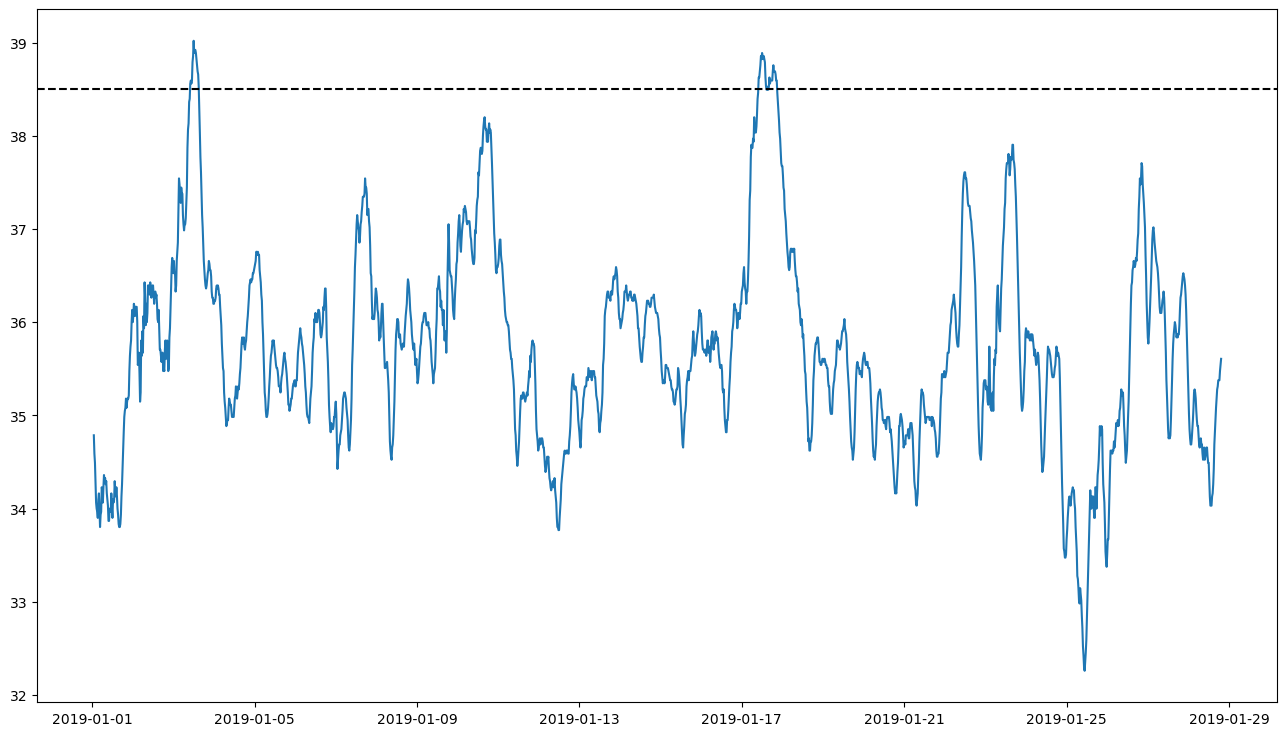

In [25]:
plt.figure(figsize=[16,9])
time_mask = np.arange(0,2000)
station_index = list(hydrodynamic_data['Stations']).index('Punta Indio KM_216')
plt.plot([datetime.fromtimestamp(time) for time in hydrodynamic_data['Times'].values[time_mask]],
         [(wlev+hydrodynamic_data['MBL'][station_index].values)*(1/feet_to_meter) for wlev in hydrodynamic_data['Water level'][station_index].values[time_mask]])
plt.axhline(35*1.1,linestyle='--',color='k')